### <트랜스 포머(T.F.) (vs) GPT1>
1. T.F.:인코더, 디코더 로 구성<br>
   GPT:디코더 만으로 구성<br>
2. T.F.:supervised learning (입력에 대한 출력 데이터가 있음)<br>
   GPT:semi-supervised learning (대규모 데이터 비지도 학습으로 pre-training 후, 지도학습 데이터로 fine-tuning)<br>
3. T.F.:decoder에서 encoder의 임베딩을 참고하는 attention block 존재<br>
   GPT:self attention block 만으로 구성<br>
5. T.F.:positional encoding을 계산해서 입력 임베딩에 더한다<br>
   GPT:positional encoding을 학습값으로 더한다.<br>



In [1]:
!pip install sentencepiece

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import sentencepiece as spm

import math
import os
import re
import numpy as np
import matplotlib.pyplot as plt

# 데이터 받아오기
대화의 쌍으로 구성된 데이터셋을 사용<br>
질문과 답변의 쌍을 추출한다.<br>
문장에서 단어와 구두점 사이에 공백을 추가한다.<br>
알파벳과 ! ? , . 이 4개의 구두점을 제외하고 다른 특수문자는 모두 제거한다.<br>

데이터 다운로드

In [15]:
# 개별 파일 경로 설정
path_to_data = 'ChatbotData .csv'

print("path_to_data:", path_to_data)

path_to_data: ChatbotData .csv


데이터 중 최대 5만개만 가져오고 질문과 답변의 쌍의 형태로 데이터셋을 가공하자

In [16]:
# 사용할 샘플의 최대 개수
#MAX_SAMPLES = 11823
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


전처리 에서는<br>
정규 표현식(Regular Expression)을 사용하여 <br>
구두점(punctuation) 을 제거하여 <br>
단어를 토크나이징(tokenizing) 하는 일에 방해가 되지 않도록 정제함

In [17]:
# 전처리 함수
def preprocess_sentence(sentence):
    # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
    sentence = sentence.lower().strip()
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    #sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)    
    #sentence = re.sub(r"[^a-zA-Z가-힣?.!,]+", " ", sentence) #완성형만 허용(가장 흔한 케이스)
    sentence = re.sub(r"[^a-zA-Z가-힣ㄱ-ㅎㅏ-ㅣ?.!,]+", " ", sentence) #완성형 + 자모까지 허용(따옴표 분리 자모 등도 보존)
    #sentence = re.sub(r"[^a-zA-Z가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence) #완성형 + 자모까지 허용(따옴표 분리 자모 등도 보존)
    sentence = sentence.strip()
    return sentence
print("슝=3")

슝=3


테스트

In [18]:
sample_sentence = "안녕하세요? Hello! I'm a student😊, nice to meet you!"

preprocessed_sentence = preprocess_sentence(sample_sentence)
print(preprocessed_sentence)

안녕하세요 ? hello ! i m a student , nice to meet you !


데이터를 로드와 동시에 <br>
전처리 함수를 호출하여 질문과 답변의 쌍을 전처리

In [19]:
import csv
def read_cornell_data(path_data, max_samples=50000):
    pairs = []
    with open(path_data, 'r', encoding='utf-8-sig', newline='') as f:
        lines = csv.reader(f)
        line = next(lines, None)  # 첫 행 버림
        for line in lines:
            q_text=line[0]
            a_text=line[1]
            #전처리
            q_text = preprocess_sentence(q_text)
            a_text = preprocess_sentence(a_text)
            pairs.append((q_text, a_text))
            if len(pairs) >= max_samples:
                return pairs
    return pairs

로드한 데이터의 샘플 수  확인

In [20]:
pairs =read_cornell_data(path_to_data, max_samples=MAX_SAMPLES)
print('전체 샘플 수 :', len(pairs))
print(f'Q:',pairs[0][0])
print(f'A:',pairs[0][1])
print(f'QA:',pairs[0])

전체 샘플 수 : 11823
Q: 시 땡 !
A: 하루가 또 가네요 .
QA: ('시 땡 !', '하루가 또 가네요 .')


# 데이터 전처리하기
1. Google SentencePiece 를 토크나이저로 사용한다.<br>
단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고, 각 토큰을 고유한 정수로 인코딩 한다.<br>
2. 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 START_TOKEN 및 END_TOKEN을 추가한다.<br>
3. 최대 길이 MAX_LENGTH 인 11을 넘는 문장들은 필터링한다.<br>
4. MAX_LENGTH보다 길이가 짧은 문장들은 11에 맞도록 패딩 한다.<br>

In [21]:
#1. 토크나이저 학습하기
#단순한 규칙 기반, 혹은 미리 준비된 토크나이저의 경우 학습이 필요하지 않지만 데이터에 맞춰 단어사전을 작성하는 경우 학습이 필요합니다.

#우선 위에서 만든 pair를 텍스트 파일에 저장시키겠습니다.
corpus_file = "clean_corpus.txt"
with open(corpus_file, 'w', encoding='utf-8') as f:
    for q, a in pairs:
        f.write(q + "\n")
        f.write(a + "\n")

VOCAB_SIZE = 10000 # 단어 집합 크기(예시)
#질문-답변 쌍이 담긴 clean_corpus.txt 파일을 이용해 SentencePiece 모델을 훈련하고, 토크나이저가 담길 model / vocab 파일을 생성하겠습니다.

spm.SentencePieceTrainer.Train(
    input=corpus_file,
    model_prefix="ko_uni32k",
    vocab_size=VOCAB_SIZE,
    character_coverage=0.9995,
    model_type="bpe",
    max_sentence_length=1000,
    bos_id=1,  # <s> (Beginning of Sentence) 설정
    eos_id=2,  # </s> (End of Sentence) 설정
    pad_id=0,  # Padding ID 설정
    unk_id=3   # Unknown Token ID 설정
)
#그럼 학습시킨 토크나이저를 불러와 테스트해보겠습니다.
sp = spm.SentencePieceProcessor()
sp.Load("ko_uni32k.model")


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: clean_corpus.txt
  input_format: 
  model_prefix: ko_uni32k
  model_type: BPE
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 1000
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  diff

True

9 size=1180 all=30895 active=1956 piece=▁좋아해
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=28 size=1200 all=30990 active=2051 piece=▁비싸
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=28 min_freq=11
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=27 size=1220 all=31042 active=1597 piece=ns
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=27 size=1240 all=31145 active=1700 piece=▁죽을
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=26 size=1260 all=31166 active=1721 piece=▁냉
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=26 size=1280 all=31262 active=1817 piece=▁어렵
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=26 size=1300 all=31335 active=1890 piece=▁만났어
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=26 min_freq=10
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=25 size=1320 all=31439 active=1671 piece=이가
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=25 size=1340 all=31547 active=1779 piece=▁��속
bpe_model_trainer.cc(268) LOG(INFO) Added:

In [40]:
# Dataset 구현하기
class korDataset(Dataset):
    def __init__(self, corpus_file, sp, window=80):
        super().__init__()
        self.sp = sp
        self.X, self.Y = [], [] #X입력, Y출력
        
        data = []
        bos_id = sp.bos_id() if sp.bos_id() >= 0 else 1  # 혹은 임의값
        eos_id = sp.eos_id() if sp.eos_id() >= 0 else 2
        pad_id = sp.pad_id() if sp.pad_id() >= 0 else 0

        #코퍼스 전체를 하나로 묶는다.
        #문장 eos 문장 eos .... 구조
        with open(corpus_file, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line: continue #빈줄 거르기
                ids = sp.EncodeAsIds(line)
                data.extend(ids) # n개의 토큰을 추가
                data.append(eos_id) #문장 마지막에 eos추가

        
        for i in range(0, len(data)-1, window):
            chunk = data[i:i+window+1] #윈도우 간에 1토큰 겹침(문장 중간 잘림 보완)
            if len(chunk) < window+1:
                # data 마지막 남는 부분 padding처리
                # 패딩 (y의 패딩 타겟은 pad_id로 두고 CE에서 ignore_index=pad_id)
                chunk = chunk + [pad_id] * (window+1 - len(chunk))
            x = torch.tensor(chunk[:-1], dtype=torch.long)
            y = torch.tensor(chunk[1:], dtype=torch.long)
            self.X.append(x); self.Y.append(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [41]:
dataset = korDataset(corpus_file, sp, window=80)

테스트

In [42]:
# (<s> 토큰의 인덱스는 1, </s> 토큰의 인덱스는 2 입니다)
print(dataset.__len__())
for i,(X, Y) in enumerate(dataset):
    print(i)
    print(X)
    print(Y)
    print(sp.decode(X.tolist()))
    print(sp.decode(Y.tolist()))
    if i==1:
        break

1866
0
tensor([  51, 3192,  108,    2, 4481,  215, 5914,    4,    2,   60, 9253, 1006,
        2453,    2, 1615, 6402,    4,    2, 4001,   65, 3489,  202,    2, 5123,
        1357,  384,    4,    2, 4001,   65,  980, 3489,  202,    2, 5123, 1357,
         384,    4,    2, 8939, 9917, 9917,    3,  316,  482,    2,  212, 5488,
        8769, 8869,    4,    2, 8624, 4069, 4137,  654,    2,  206, 2557, 1002,
          91,   54,  241,  110,    4,    2, 8624, 4069,  473,    2,  206, 2557,
        1002,   91,   54,  241,  110,    4,    2, 1297])
tensor([3192,  108,    2, 4481,  215, 5914,    4,    2,   60, 9253, 1006, 2453,
           2, 1615, 6402,    4,    2, 4001,   65, 3489,  202,    2, 5123, 1357,
         384,    4,    2, 4001,   65,  980, 3489,  202,    2, 5123, 1357,  384,
           4,    2, 8939, 9917, 9917,    3,  316,  482,    2,  212, 5488, 8769,
        8869,    4,    2, 8624, 4069, 4137,  654,    2,  206, 2557, 1002,   91,
          54,  241,  110,    4,    2, 8624, 4069,  473, 

In [43]:
#3. DataLoader 구성하기
dataloader = DataLoader(dataset,batch_size=32,shuffle=True)

데이터 로더 확인<br>
데이터 로더의 경우 일반적인 인덱싱 방식으로 불러올 경우 에러가 나기 때문에 아래와 같이 for 문을 활용해 불러옵니다. 이미 데이터가 잘 들어있는지는 확인했기 때문에 여기에서는 batch 단위로 잘 불러와지는지만 확인하도록 하겠습니다.

In [44]:
#데이터 로더의 경우 일반적인 인덱싱 방식으로 불러올 경우 에러가 나기 때문에 아래와 같이 for 문을 활용해 불러옵니다. 이미 데이터가 잘 들어있는지는 확인했기 때문에 여기에서는 batch 단위로 잘 불러와지는지만 확인하도록 하겠습니다.
for X, Y in dataloader:
    print(X.size())
    print(Y.size())
    break


torch.Size([32, 80])
torch.Size([32, 80])


# Positional Encoding

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.position = position

        self.pos_encoding = self._build_pos_encoding(position, d_model)

    def _get_angles(self, position, i, d_model):
        return 1.0 / (10000.0 ** ((2.0 * (i // 2)) / d_model)) * position

    def _build_pos_encoding(self, position, d_model):
        pos = torch.arange(position, dtype=torch.float32).unsqueeze(1)
        i = torch.arange(d_model, dtype=torch.float32).unsqueeze(0)

        angle_rads = self._get_angles(pos, i, d_model)
        sines = torch.sin(angle_rads[:, 0::2])
        cosines = torch.cos(angle_rads[:, 1::2])

        pos_encoding = torch.zeros(position, d_model)
        pos_encoding[:, 0::2] = sines
        pos_encoding[:, 1::2] = cosines

        pos_encoding = pos_encoding.unsqueeze(0)  # shape: [1, position, d_model]
        return pos_encoding

    def forward(self, x):
        return x + self.pos_encoding[:, :x.size(1), :].to(x.device)

### Positional Encoding 시각화

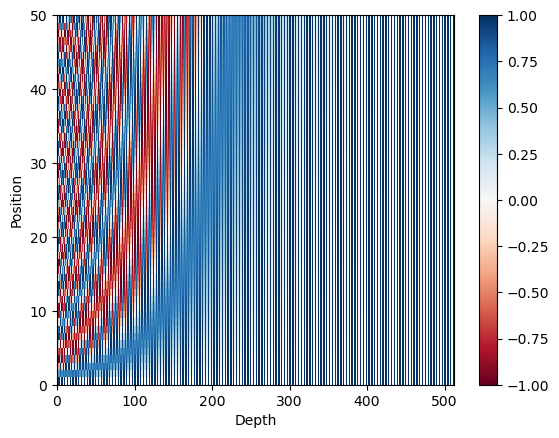

In [4]:
#최대 문장 길이가 50이고 워드 임베딩 차원 512 인 모델의 입력 벡터 모양
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# Scaled dot product Attention
### Attention(Q,K,V)=softmax(QK^T/sqrt(d_k))

In [5]:
def scaled_dot_product_attention(query, key, value, mask=None):

    # 1) Q와 K의 내적을 통해 score(유사도) 계산
    # key.transpose(-1, -2): (batch_size, heads, depth, seq_len)
    # matmul 결과 shape: (batch_size, heads, seq_len, seq_len)
    matmul_qk = torch.matmul(query, key.transpose(-1, -2))

    # 2) depth에 따라 정규화
    depth = key.size(-1)  # depth = d_model / heads
    logits = matmul_qk / math.sqrt(depth)

    # 3) 마스크가 주어졌다면 -1e9(아주 작은 값)를 더해 소프트맥스에서 제외시키도록 함
    if mask is not None:
        # 텐서플로우: logits += (mask * -1e9)
        # 파이토치 동일 적용
        logits = logits + (mask * -1e9)

    # 4) 소프트맥스 계산해 attention weights 생성
    attention_weights = F.softmax(logits, dim=-1)

    # 5) attention weights와 value의 내적
    output = torch.matmul(attention_weights, value)

    return output, attention_weights

# Multihead Attention
내부적으로는 Scaled dot product Attention 함수를 호출

In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        # d_model은 num_heads로 나누어떨어져야 함
        assert d_model % num_heads == 0

        self.depth = d_model // num_heads

        # 파이토치에서 Dense는 nn.Linear로 대응
        self.query_dense = nn.Linear(d_model, d_model)
        self.key_dense = nn.Linear(d_model, d_model)
        self.value_dense = nn.Linear(d_model, d_model)

        self.out_dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        """
        x: (batch_size, seq_len, d_model)
        => (batch_size, num_heads, seq_len, depth) 형태로 변환
        """
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        x = x.permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, depth)
        return x

    def forward(self, query, key, value, mask=None):
        """
        query, key, value: (batch_size, seq_len, d_model)
        mask: (batch_size, 1, seq_len, seq_len) 등으로 broadcast 가능하도록 구성
        """
        batch_size = query.size(0)

        # Q, K, V에 각각 Linear 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # Head 분할
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)

        # (batch_size, num_heads, seq_len, depth) -> (batch_size, seq_len, num_heads, depth)
        scaled_attention = scaled_attention.permute(0, 2, 1, 3).contiguous()

        # 다시 (batch_size, seq_len, d_model)로 합치기
        concat_attention = scaled_attention.view(batch_size, -1, self.d_model)

        # 최종 Dense
        output = self.out_dense(concat_attention)
        return output


# Padding Masking

In [7]:
#오직 숫자가 0인 위치에서만 숫자 1이 나오고 숫자 0이 아닌 위치에서는 숫자 0인 벡터를 출력합니다.
def create_padding_mask(x):
    # x == 0 위치를 찾아 float형 1로 변환
    mask = (x == 0).float()
    # (batch_size, seq_len) -> (batch_size, 1, 1, seq_len)
    mask = mask.unsqueeze(1).unsqueeze(2)
    return mask

테스트

In [8]:
# 두 개의 정수 시퀀스를 입력으로 결과 확인
x = torch.tensor([[1, 2, 0, 3, 0],
                  [0, 0, 0, 4, 5]])
mask = create_padding_mask(x)
print("입력 텐서 크기 :", x.shape)    # (2, 5)
print("생성된 마스크 크기 :", mask.shape)  # (2, 1, 1, 5)
print(mask)
#두 정수 시퀀스에 대해서 각각 결과가 출력되는데, 오직 숫자가 0인 위치에서만 숫자 1이 나오고 숫자 0이 아닌 위치에서는 숫자 0인 벡터를 출력합니다.

입력 텐서 크기 : torch.Size([2, 5])
생성된 마스크 크기 : torch.Size([2, 1, 1, 5])
tensor([[[[0., 0., 1., 0., 1.]]],


        [[[1., 1., 1., 0., 0.]]]])


# Look-ahead masking
다음 단어 가리기

In [9]:
def create_look_ahead_mask(x):
    seq_len = x.size(1)

    # (seq_len, seq_len) 크기의 하삼각 행렬(tril) 생성 후 1에서 빼서
    # 상삼각이 1, 하삼각(자기 자신 포함)이 0이 되도록 설정
    # => 미래 토큰(자신 인덱스보다 큰 위치) 마스킹
    look_ahead_mask = 1 - torch.tril(torch.ones((seq_len, seq_len)))

    # 패딩 마스크 생성 (shape: (batch_size, 1, 1, seq_len))
    padding_mask = create_padding_mask(x)

    # look_ahead_mask: (seq_len, seq_len) -> (1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(0)
    # -> (1, seq_len, seq_len) -> (1, 1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(1)
    look_ahead_mask = look_ahead_mask.to(x.device)

    # look-ahead 마스크와 패딩 마스크를 합성 (둘 중 하나라도 1이면 마스킹)
    # 최종 shape은 브로드캐스팅으로 (batch_size, 1, seq_len, seq_len)
    combined_mask = torch.max(look_ahead_mask, padding_mask)
    return combined_mask

In [10]:
x = torch.tensor([[1, 2, 3, 4, 5]])
mask_1 = create_look_ahead_mask(x)
print("첫 번째 시퀀스:\n", mask_1, mask_1.shape)

#숫자 0이 포함되면 패딩하는지 테스트
#대각선의 형태로 숫자 1이 채워지는 것을 볼 수 있습니다. 그런데 이 마스킹과 패딩 마스킹은 별개이므로, 이 마스킹을 수행할 때 만약에 숫자 0인 단어가 있다면 이 또한 패딩 해야 합니다. 그래서 create_look_ahead_mask() 함수는 내부적으로 앞서 구현한 패딩 마스크 함수도 호출하고 있습니다.
x2 = torch.tensor([[0, 5, 1, 5, 5]])
mask_2 = create_look_ahead_mask(x2)
print("두 번째 시퀀스:\n", mask_2, mask_2.shape)

첫 번째 시퀀스:
 tensor([[[[0., 1., 1., 1., 1.],
          [0., 0., 1., 1., 1.],
          [0., 0., 0., 1., 1.],
          [0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 0.]]]]) torch.Size([1, 1, 5, 5])
두 번째 시퀀스:
 tensor([[[[1., 1., 1., 1., 1.],
          [1., 0., 1., 1., 1.],
          [1., 0., 0., 1., 1.],
          [1., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0.]]]]) torch.Size([1, 1, 5, 5])


# single Encoder layer

In [11]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)  # 이전에 구현한 MHA
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 피드포워드 부분 (Dense -> ReLU -> Dense)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, d_model)
        )
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

    def forward(self, x, mask=None):
        # (1) 멀티 헤드 어텐션 (셀프 어텐션)
        attn_output = self.mha(x, x, x, mask)  # (batch_size, seq_len, d_model)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(x + attn_output)     # 잔차 연결 + LayerNorm

        # (2) 피드포워드 신경망
        ffn_output = self.ffn(out1)            # (batch_size, seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.norm2(out1 + ffn_output)   # 잔차 연결 + LayerNorm

        return out2

# Encoder
### 인코더 층을 쌓아 인코더 만들기

In [12]:
class Encoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) EncoderLayer 쌓기
        self.enc_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        # (1) 임베딩 & sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 적용 + 드롭아웃
        x = self.pos_encoding(x)  # shape: (batch_size, seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓아올린 EncoderLayer 통과
        for layer in self.enc_layers:
            x = layer(x, mask)

        return x

# single Decoder layer

In [13]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # 첫 번째 서브 레이어 (디코더 내부 셀프 어텐션)
        self.self_mha = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 두 번째 서브 레이어 (인코더-디코더 어텐션)
        self.encdec_mha = MultiHeadAttention(d_model, num_heads)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

        # 세 번째 서브 레이어 (피드포워드 네트워크)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),  # Dense(units=ff_dim)
            nn.ReLU(),                   # activation='relu'
            nn.Linear(ff_dim, d_model)   # Dense(units=d_model)
        )
        self.norm3 = nn.LayerNorm(d_model, eps=1e-6)

        # 드롭아웃
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
        # 1) 셀프 어텐션 (디코더 내부)
        self_attn_out = self.self_mha(x, x, x, mask=look_ahead_mask)
        self_attn_out = self.dropout1(self_attn_out)
        out1 = self.norm1(x + self_attn_out)  # 잔차 연결 + LayerNorm

        # 2) 인코더-디코더 어텐션
        encdec_attn_out = self.encdec_mha(out1, enc_outputs, enc_outputs, mask=padding_mask)
        encdec_attn_out = self.dropout2(encdec_attn_out)
        out2 = self.norm2(out1 + encdec_attn_out)  # 잔차 연결 + LayerNorm

        # 3) 피드포워드 (Dense -> ReLU -> Dense)
        ffn_out = self.ffn(out2)
        ffn_out = self.dropout3(ffn_out)
        out3 = self.norm3(out2 + ffn_out)  # 잔차 연결 + LayerNorm

        return out3

# Decoder
### 디코더 층을 쌓아 디코더 만들기

In [14]:
class Decoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        # 실제 학습 시에는 최대 시퀀스 길이에 맞추어 쓰기도 함
        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) DecoderLayer 쌓기
        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
        # (1) 임베딩 + sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 + 드롭아웃
        x = self.pos_encoding(x)    # (batch_size, tgt_seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓인 DecoderLayer 통과
        for layer in self.dec_layers:
            x = layer(x, enc_outputs, look_ahead_mask, padding_mask)

        return x

# ========================================================================================

# 모델 정의 및 학습하기

 인코더 층 함수와 디코더 층 함수를 사용하여 트랜스포머 함수를 정의

In [30]:
class Transformer(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,      # 인코더/디코더 층 수
                 units,           # feed-forward 네트워크의 중간 차원(ff_dim)
                 d_model,         # 임베딩 및 내부 표현 차원
                 num_heads,       # 멀티헤드 어텐션의 헤드 수
                 dropout=0.1):
        super(Transformer, self).__init__()

        # 인코더
        self.encoder = Encoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 디코더
        self.decoder = Decoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 최종 출력층: (d_model) -> (vocab_size)
        self.final_linear = nn.Linear(d_model, vocab_size)

        # 참고: 텐서플로우 코드의 `name="transformer"`는 파이토치에선 보통 사용 안 함

    def forward(self, inputs, dec_inputs):
        # 1) 인코더 패딩 마스크 생성
        enc_padding_mask = create_padding_mask(inputs)     # shape (batch_size, 1, 1, src_seq_len)

        # 2) 디코더 look-ahead + 패딩 마스크
        look_ahead_mask = create_look_ahead_mask(dec_inputs)  # shape (batch_size, 1, tgt_seq_len, tgt_seq_len)

        # 3) 디코더에서 인코더 출력 쪽을 마스킹할 때 쓸 패딩 마스크
        dec_padding_mask = create_padding_mask(inputs)        # shape (batch_size, 1, 1, src_seq_len)

        # 4) 인코더 수행
        enc_outputs = self.encoder(
            x=inputs,
            mask=enc_padding_mask
        )  # shape: (batch_size, src_seq_len, d_model)

        # 5) 디코더 수행
        dec_outputs = self.decoder(
            x=dec_inputs,           # (batch_size, tgt_seq_len)
            enc_outputs=enc_outputs,# (batch_size, src_seq_len, d_model)
            look_ahead_mask=look_ahead_mask,
            padding_mask=dec_padding_mask
        )  # shape: (batch_size, tgt_seq_len, d_model)

        # 6) 최종 Dense (vocab_size)
        logits = self.final_linear(dec_outputs)  # (batch_size, tgt_seq_len, vocab_size)
        return logits

1. 모델 생성

In [31]:
# 예: 하이퍼파라미터 설정
NUM_LAYERS = 2 #4#2     # 인코더/디코더 층 수 (논문에서는 6)
D_MODEL = 256      # 임베딩 및 내부 표현 차원 (논문에서는 512)
NUM_HEADS = 8      # 멀티헤드 어텐션에서의 헤드 수
UNITS = 512        # 피드포워드 신경망의 은닉 차원
DROPOUT = 0.1      # 드롭아웃 비율

# 모델 생성
model = Transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)

print(model)

Transformer(
  (encoder): Encoder(
    (embedding): Embedding(10000, 256)
    (pos_encoding): PositionalEncoding()
    (dropout): Dropout(p=0.1, inplace=False)
    (enc_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (mha): MultiHeadAttention(
          (query_dense): Linear(in_features=256, out_features=256, bias=True)
          (key_dense): Linear(in_features=256, out_features=256, bias=True)
          (value_dense): Linear(in_features=256, out_features=256, bias=True)
          (out_dense): Linear(in_features=256, out_features=256, bias=True)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=256, bias=True)
        )
        (dropout2): Dropout(p=0.1, inplace=False)
        (norm2): LayerNorm((256,), eps=1e-06, elementwise_af

2. 손실 함수(Loss function)<br>
레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 합니다.

In [32]:
loss_function = nn.CrossEntropyLoss(ignore_index=sp.pad_id())

3. 커스텀 된 학습률(Learning rate)


In [33]:
def get_lr_lambda(d_model, warmup_steps=4000):
    d_model = float(d_model)
    def lr_lambda(step):
        # step은 0부터 시작하므로 +1로 보정
        step = step + 1
        return (d_model ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))
    return lr_lambda

커스텀 된 학습률 스케줄링 시각화 확인

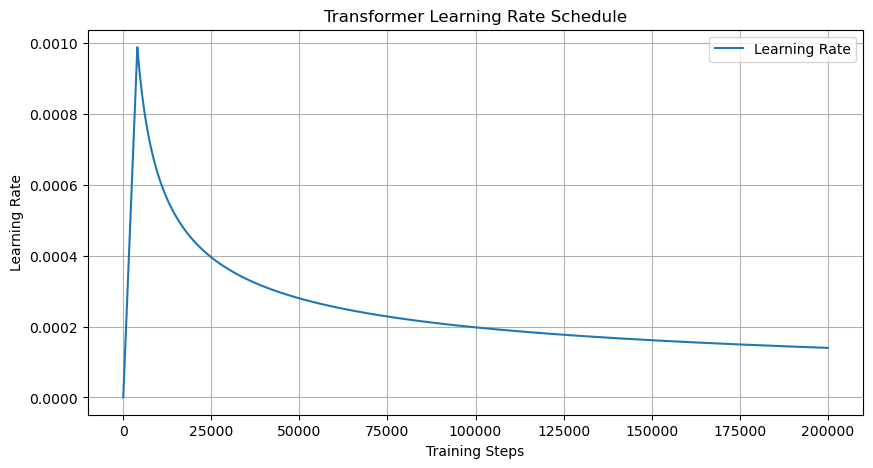

In [34]:
# 하이퍼파라미터 설정
d_model = D_MODEL
warmup_steps = 4000
total_steps = 200000  # 총 학습 스텝

# 학습률 스케줄 시각화
steps = np.arange(1, total_steps + 1)
learning_rates = [get_lr_lambda(d_model, warmup_steps)(step) for step in steps]

# 그래프 출력
plt.figure(figsize=(10, 5))
plt.plot(steps, learning_rates, label="Learning Rate")
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.title("Transformer Learning Rate Schedule")
plt.legend()
plt.grid(True)
plt.show()


4. 모델 컴파일

In [35]:
# Optimizer 정의
optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-9)

# Scheduler 정의
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda(D_MODEL, warmup_steps=4000))

def accuracy_function(y_pred, y_true, pad_id=0):
    """
    y_pred: (batch_size, seq_len, vocab_size)
    y_true: (batch_size, seq_len)
    """
    preds = y_pred.argmax(dim=-1)  # (batch_size, seq_len)
    mask = (y_true != pad_id)
    correct = (preds == y_true) & mask
    acc = correct.float().sum() / mask.float().sum()
    return acc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

5. 훈련하기

In [36]:
def train_step(model, batch, optimizer, loss_function, device):
    model.train()
    enc_input, dec_input, target = [x.to(device) for x in batch]

    optimizer.zero_grad()

    # 모델 포워드 패스
    logits = model(enc_input, dec_input)  # (batch_size, seq_len, vocab_size)

    # Loss 계산 (패딩 토큰 무시)
    loss = loss_function(logits.permute(0, 2, 1), target)  # (batch_size, vocab_size, seq_len) 필요

    # Backpropagation
    loss.backward()
    optimizer.step()

    return loss.item(), accuracy_function(logits, target, pad_id=sp.pad_id())

In [37]:
def train(model, dataloader, optimizer, loss_function, scheduler, num_epochs, device):
    model.to(device)

    for epoch in range(num_epochs):
        total_loss, total_acc = 0, 0
        for step, batch in enumerate(dataloader):
            loss, acc = train_step(model, batch, optimizer, loss_function, device)
            total_loss += loss
            total_acc += acc

            # 일정 스텝마다 로그 출력
            if step % 100 == 0:
                print(f"[Epoch {epoch+1}, Step {step}] Loss: {loss:.4f}, Acc: {acc:.4f}")

            # 학습률 스케줄러 업데이트
            scheduler.step()

        avg_loss = total_loss / len(dataloader)
        avg_acc = total_acc / len(dataloader)
        print(f"Epoch {epoch+1} Completed - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.4f}")

In [38]:
%%time

train(
    model=model,
    dataloader=dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    scheduler=scheduler,
    num_epochs=25, # 원하는 에폭 수
    device=device
)

[Epoch 1, Step 0] Loss: 9.1992, Acc: 0.0000
[Epoch 1, Step 100] Loss: 9.2191, Acc: 0.0000
[Epoch 1, Step 200] Loss: 9.1918, Acc: 0.0000
[Epoch 1, Step 300] Loss: 9.1557, Acc: 0.0000
Epoch 1 Completed - Avg Loss: 9.2219, Avg Acc: 0.0000
[Epoch 2, Step 0] Loss: 9.1727, Acc: 0.0000
[Epoch 2, Step 100] Loss: 9.1428, Acc: 0.0000
[Epoch 2, Step 200] Loss: 9.2597, Acc: 0.0000
[Epoch 2, Step 300] Loss: 9.2284, Acc: 0.0000
Epoch 2 Completed - Avg Loss: 9.1896, Avg Acc: 0.0000
[Epoch 3, Step 0] Loss: 9.1579, Acc: 0.0000
[Epoch 3, Step 100] Loss: 9.1556, Acc: 0.0000
[Epoch 3, Step 200] Loss: 9.0659, Acc: 0.0000
[Epoch 3, Step 300] Loss: 9.1383, Acc: 0.0000


KeyboardInterrupt: 

# 챗봇 테스트하기

예측(inference) 단계는 기본적으로 다음과 같은 과정을 거칩니다.<br>

1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.<br>

위의 과정을 모두 담은 decoder_inference() 함수를 만듭니다.

In [ ]:
def decoder_inference(model, sentence, tokenizer, device='cpu'):
    START_TOKEN = tokenizer.bos_id()
    END_TOKEN = tokenizer.eos_id()
    MAX_LENGTH = 40


    # 전처리
    sentence = preprocess_sentence(sentence)

    # 인코더 입력: [START] + 인코딩 + [END]
    enc_input_ids = [START_TOKEN] + tokenizer.encode(sentence) + [END_TOKEN]
    # 차원 확장: (batch_size=1, seq_len)
    enc_input = torch.tensor([enc_input_ids], dtype=torch.long, device=device)

    # 디코더 입력(dec_input)을 START_TOKEN만 포함한 상태로 시작
    dec_input = torch.tensor([[START_TOKEN]], dtype=torch.long, device=device)

    model.eval()  # 모델 평가 모드
    with torch.no_grad():
        for i in range(MAX_LENGTH):
            # 모델 forward: (enc_input, dec_input) -> (batch_size=1, seq_len, vocab_size)
            logits = model(enc_input, dec_input)

            # 마지막 타임스텝의 예측만 추출: shape (1, 1, vocab_size)
            # logits[:, -1, :] -> (1, vocab_size)
            last_step_logits = logits[:, -1, :]

            # argmax로 가장 높은 확률의 토큰 선택
            predicted_id = torch.argmax(last_step_logits, dim=-1)  # shape: (1,)

            # 종료 토큰이면 중단
            if predicted_id.item() == END_TOKEN:
                break

            # 디코더 입력(dec_input)에 예측 토큰을 이어붙임
            predicted_id = predicted_id.unsqueeze(0)  # shape (1,1)
            dec_input = torch.cat([dec_input, predicted_id], dim=1)

    # 최종 시퀀스: dec_input: (1, seq_len)에서 (seq_len,)로
    output_sequence = dec_input.squeeze(0).tolist()  # e.g. [START_TOKEN, ..., 토큰들...]

    return output_sequence

임의의 입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 sentence_generation() 함수를 만듭니다.

In [ ]:
def sentence_generation(model, sentence, tokenizer, device='cpu'):
    # 디코더 인퍼런스 -> 예측된 토큰 시퀀스
    output_seq = decoder_inference(model, sentence, tokenizer, device=device)

    # 토크나이저로 디코딩 (패딩, START/END 토큰 등은 제외하거나 처리)
    # 여기서는 단순히 tokenizer.decode() 직접 호출
    predicted_sentence = tokenizer.decode(
        [token for token in output_seq if token < tokenizer.GetPieceSize()]
    )

    print("입력 :", sentence)
    print("출력 :", predicted_sentence)
    return predicted_sentence

임의의 문장으로부터 챗봇의 대답을 얻어봅시다.

In [ ]:
sentence = '친구 온대'
sentence_generation(model, sentence, sp, device)

sentence = "친구가 소심해"
sentence_generation(model, sentence, sp, device)


학습은 되었으나, 학습율이 일정 이상 오르지 않고 출력도 "." 밖에 나오지 않았다.
데이터의 양이 적다고 하기엔 출력이 너무 나오지 않아서 다른 문제가 있을 것으로 생각된다.

데이터 불러오기: A 과 Q 이 이미 나누어져 있는 csv 파일을 사용하였으므로, 데이터를 불러와서 사용하는건 예제보다 쉬웠다.

SentencePieceTrainer의 model_prefix 를"ko_uni32k" 로 설정하고 여러 하이퍼 파라메타를 수정해봤다.
1. 특수 문자 전처리: 모든 특수문자를 지우고 테스트 해봤는데 눈에 띄게 학습률이 떨어졌다.
2. 인코더/디코더 layer 수: 2층->4층 으로 바꾸어 보았으나 유의미한 변화는 없었다.
3. 문장 별 토큰의 분포를 보고 11개 길이까지만 사용하였다. 약간의 변화는 있었으나 크게 달라지진 않았다.
4. epoch 변화: epoch를 크게 늘려 보았으나 20 전후로 30미만에서 학습률이 더 이상 오르지 않았다.
5. vocab 늘이기 8000 -> 10000: 더 크게 늘이면 학습 시간이 너무 오려걸려서 중단했다. 크게 유의미한 변화는 없었다.
6. 희소한 문자를 배제하기 위해 SentencePieceTrainer의 character_coverage를 0.9995(상위 99.95% 사용)로 설정했다.